<a href="https://colab.research.google.com/github/kirath2205/Neural-Network-Assignment-1/blob/pramurta/start_1b_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers import ...

from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup, Flatten

In [3]:
import pandas as pd
df = pd.read_csv('hdb_price_prediction.csv')
df.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [12]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="one_hot") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


# **Question 1**

**Part A**

In [13]:
#Split data
train_dataframe = df[df['year'] <= 2020] # 0.8393471285568813
val_dataframe = df[df['year'] > 2020]

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

In [14]:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature(month, "month", train_ds, False)





# Categorical feature encoded as string

storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)


flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)



# Numerical features
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

all_features = layers.concatenate(
    [
        month_encoded,
        flat_model_type_encoded,
        storey_range_encoded,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded
    ]
)




In [15]:
all_inputs = [
        month,
        flat_model_type,
        storey_range,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby
    ]

In [17]:
# feedforward network with one hidden layer
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)

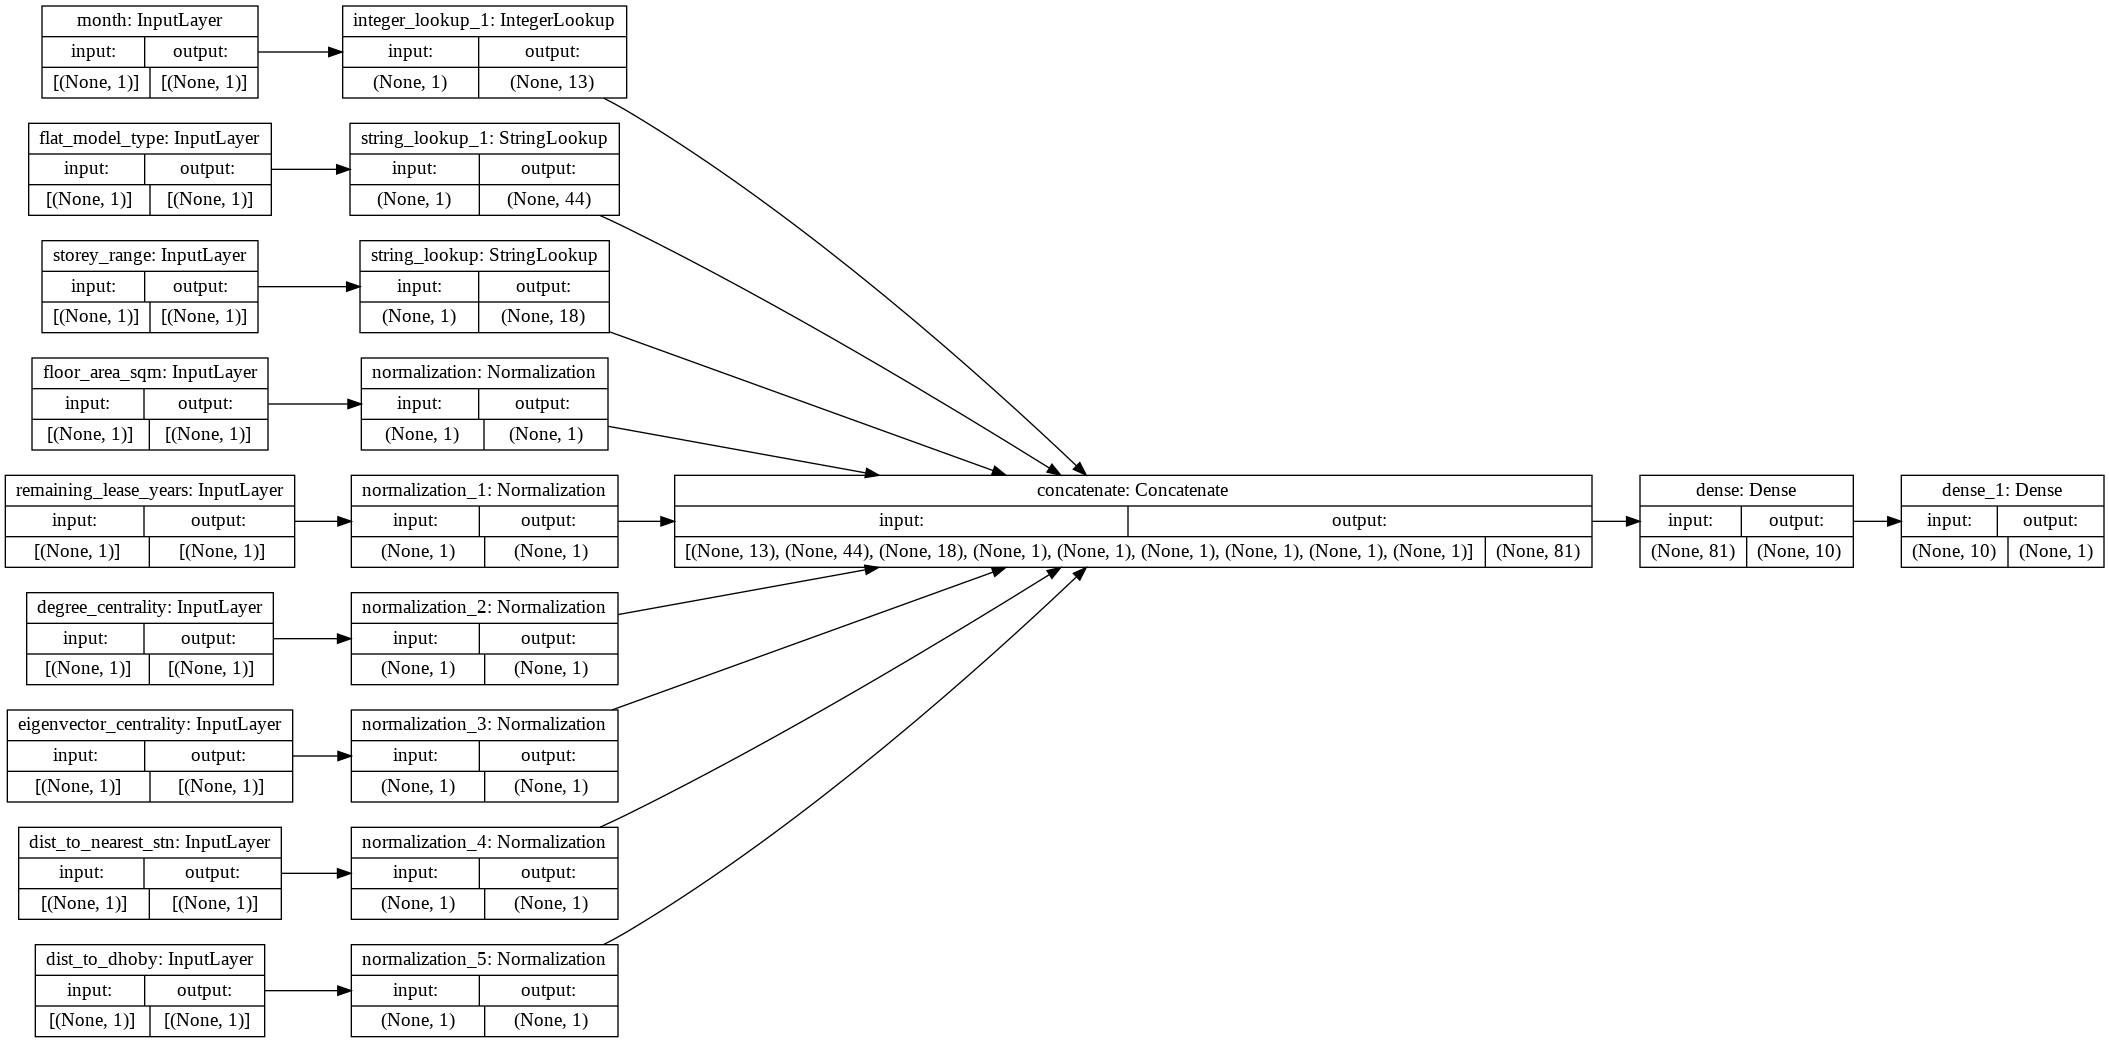

In [18]:
model = keras.Model(all_inputs, output)
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
from keras import backend as K

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=[R2])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
flat_model_type (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
storey_range (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
floor_area_sqm (InputLayer)     [(None, 1)]          0                                            
______________________________________________________________________________________________

In [ ]:
history = model.fit(train_ds, epochs=100, validation_data=val_ds)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 4s 5ms/step - loss: 187175714816.0000 - R2: -7.0488 - val_loss: 170701799424.0000 - val_R2: -5.6974
Epoch 2/100
683/683 [==============================] - 3s 4ms/step - loss: 67175251968.0000 - R2: -1.8795 - val_loss: 39795949568.0000 - val_R2: -0.5496
Epoch 3/100
683/683 [==============================] - 3s 4ms/step - loss: 10803833856.0000 - R2: 0.5421 - val_loss: 11000638464.0000 - val_R2: 0.5751
Epoch 4/100
683/683 [==============================] - 3s 4ms/step - loss: 5527165440.0000 - R2: 0.7650 - val_loss: 8574937088.0000 - val_R2: 0.6689
Epoch 5/100
683/683 [==============================] - 3s 4ms/step - loss: 4987610112.0000 - R2: 0.7872 - val_loss: 7978337792.0000 - val_R2: 0.6912
Epoch 6/100
683/683 [==============================] - 3s 4ms/step - loss: 4625724416.0000 - R2: 0.8025 - val_loss: 7678568960.0000 - val_R2: 0.7038
Epoch 7/100
683/683 [==============================] - 3s 4ms/step - loss: 4363144192.0000 - R2: 0.8140 - 

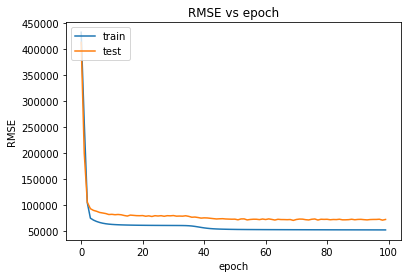

In [ ]:
import math
import matplotlib.pyplot as plt

history.history['root_mean_squared_error'] = []
history.history['val_root_mean_squared_error'] = []

for i in range(len(history.history['loss'])):
    history.history['root_mean_squared_error'].append(math.sqrt(history.history['loss'][i]))

for i in range(len(history.history['val_loss'])):
    history.history['val_root_mean_squared_error'].append(math.sqrt(history.history['val_loss'][i]))

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('RMSE vs epoch')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
test_loss = history.history['val_loss']

min_epoch_loss = 0
min_loss = float("inf")
for i,loss in enumerate(test_loss):
    if loss<min_loss:
        min_loss = loss
        min_epoch_loss = i+1

print(min_epoch_loss)



70


In [ ]:
history.history['val_R2'][69]

0.8073295950889587

In [19]:
model1 = keras.Model(all_inputs, output)

from keras import backend as K

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model1.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=[R2])

checkpoint_filepath = '/content/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

new_history = model1.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[model_checkpoint_callback])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 4s 5ms/step - loss: 195954900992.0000 - R2: -7.4419 - val_loss: 198356500480.0000 - val_R2: -6.7680
Epoch 2/100
683/683 [==============================] - 3s 4ms/step - loss: 95820873728.0000 - R2: -3.1184 - val_loss: 71856873472.0000 - val_R2: -1.8082
Epoch 3/100
683/683 [==============================] - 3s 4ms/step - loss: 22768435200.0000 - R2: 0.0260 - val_loss: 18123272192.0000 - val_R2: 0.2970
Epoch 4/100
683/683 [==============================] - 3s 4ms/step - loss: 6651905536.0000 - R2: 0.7179 - val_loss: 9643603968.0000 - val_R2: 0.6278
Epoch 5/100
683/683 [==============================] - 3s 4ms/step - loss: 5374145536.0000 - R2: 0.7710 - val_loss: 8449500672.0000 - val_R2: 0.6721
Epoch 6/100
683/683 [==============================] - 3s 4ms/step - loss: 4958282240.0000 - R2: 0.7883 - val_loss: 8094582784.0000 - val_R2: 0.6873
Epoch 7/100
683/683 [==============================] - 3s 4ms/step - loss: 4640888320.0000 - R2: 0.8021 - 

In [20]:
model1.load_weights(checkpoint_filepath)

In [21]:
y_pred = model1.predict(val_ds)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


In [22]:
y_pred_128 = np.array(y_pred[:128])

In [23]:
y_true = np.array(np.concatenate([y for x, y in val_ds], axis=0))

In [24]:
y_true_128 = np.array(y_true[:128])

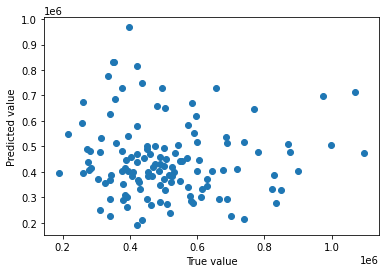

In [25]:
import matplotlib.pyplot as plt
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.scatter(y_true_128, y_pred_128)

In [26]:
emb_model = tf.keras.Sequential()

# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature(month, "month", train_ds, False)
month_embedder = tf.keras.layers.Embedding(input_dim = month_encoded.shape[1], output_dim = (month_encoded.shape[1]-1)//2, trainable=True)(month_encoded)
month_embedder_flattened = Flatten()(month_embedder)





# Categorical feature encoded as string

storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)
storey_range_embedder = tf.keras.layers.Embedding(input_dim = storey_range_encoded.shape[1], output_dim = (storey_range_encoded.shape[1]-1)//2, trainable=True)(storey_range_encoded)
storey_range_embedder_flattened = Flatten()(storey_range_embedder)


flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
flat_model_type_embedder = tf.keras.layers.Embedding(input_dim = flat_model_type_encoded.shape[1], output_dim = (flat_model_type_encoded.shape[1]-1)//2, trainable=True)(flat_model_type_encoded)
flat_model_type_embedder_flattened = Flatten()(flat_model_type_embedder)




# Numerical features
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)






In [27]:


all_features = layers.concatenate(
    [
        month_embedder_flattened,
        flat_model_type_embedder_flattened,
        storey_range_embedder_flattened,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded
    ]
)

all_inputs = [
        month,
        flat_model_type,
        storey_range,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby
    ]

In [28]:
# feedforward network with one hidden layer
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)

model1 = keras.Model(all_inputs, output)



In [29]:
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
flat_model_type (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
storey_range (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
integer_lookup_2 (IntegerLookup (None, 13)           0           month[0][0]                      
____________________________________________________________________________________________

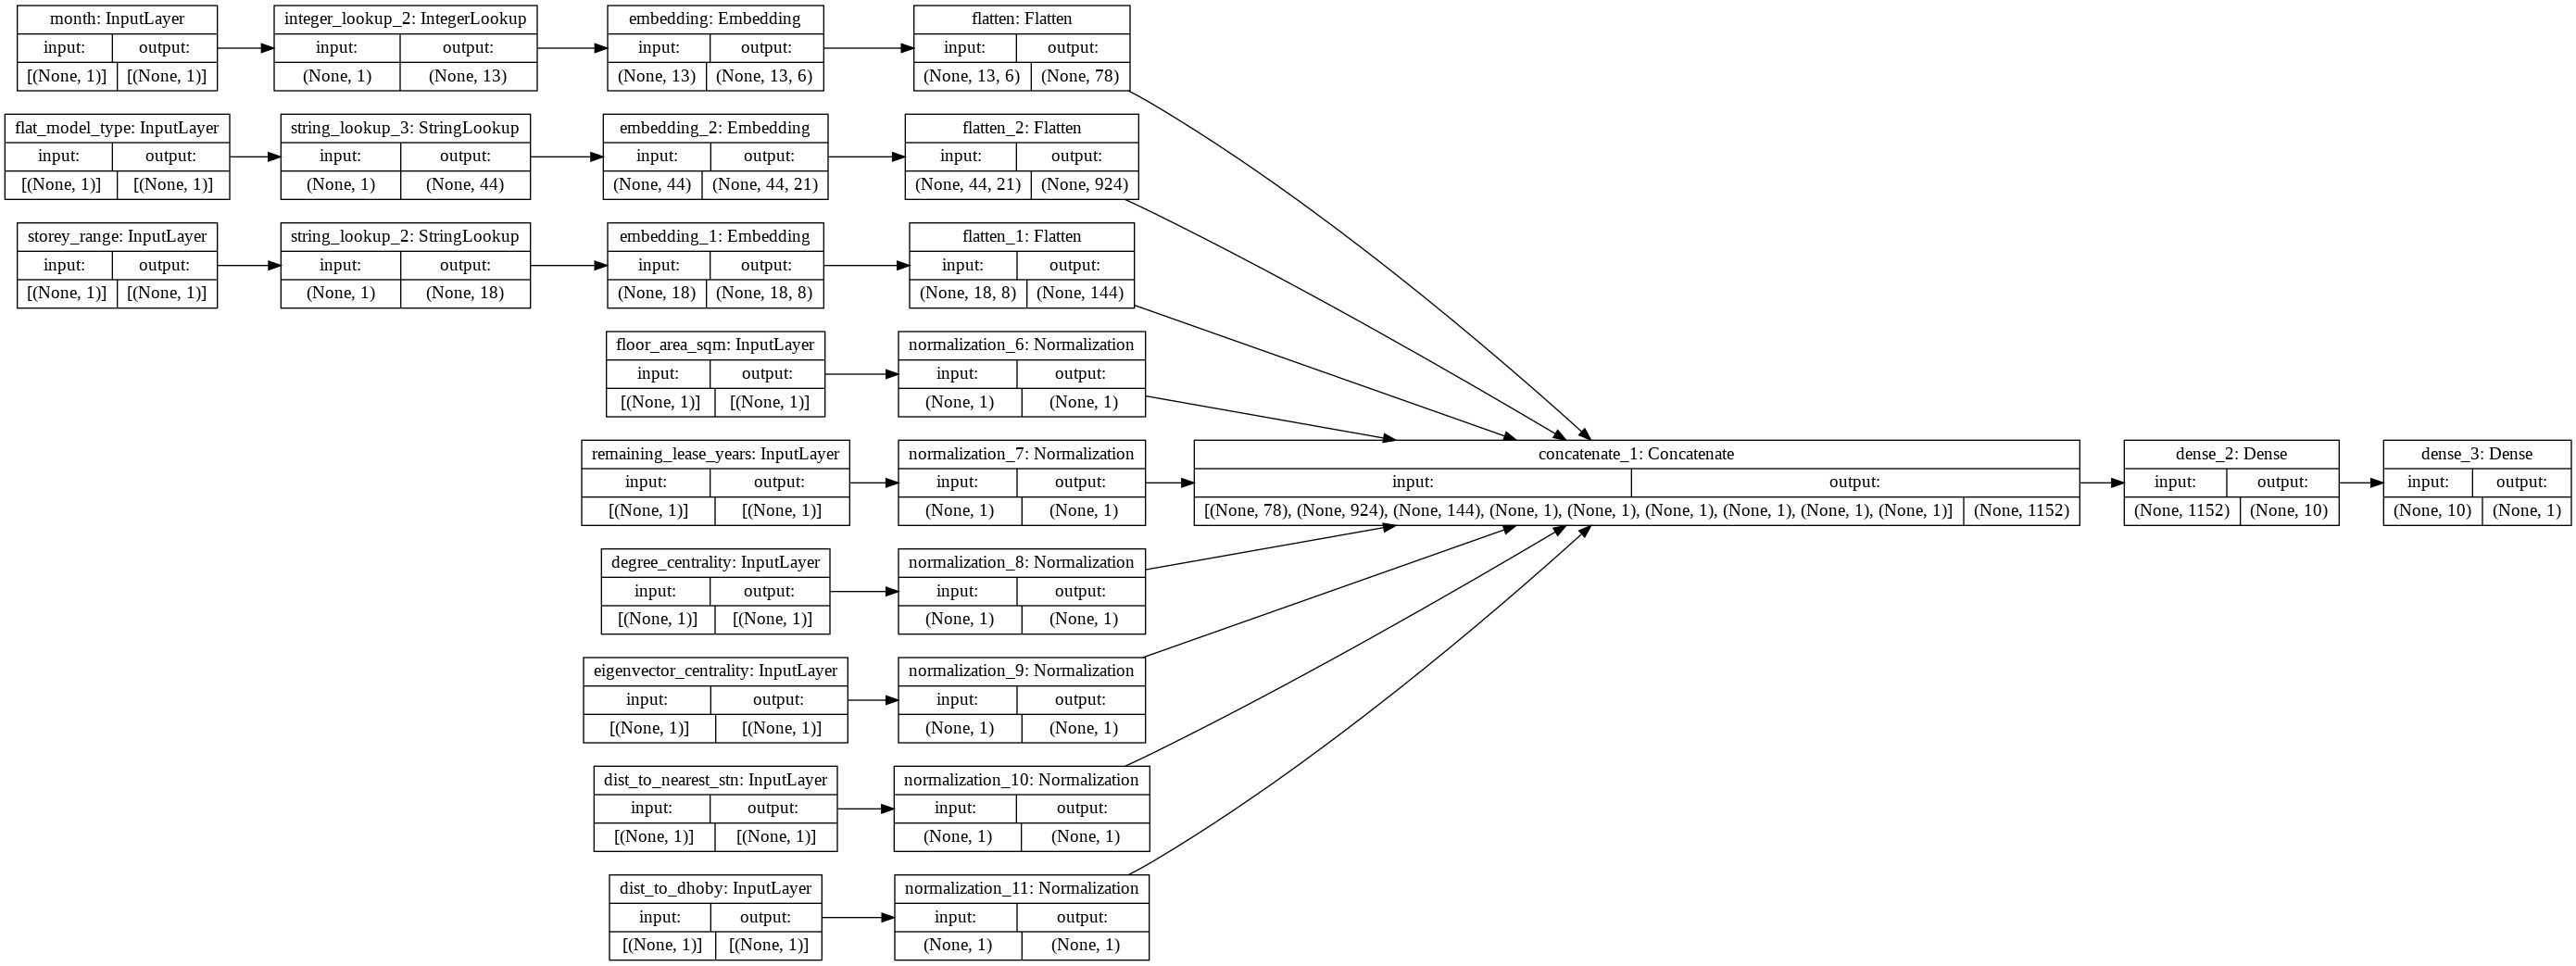

In [30]:
keras.utils.plot_model(model1, show_shapes=True, rankdir="LR")

In [31]:
from keras import backend as K

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model1.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=[R2])

In [32]:
history1 = model1.fit(train_ds, epochs=100, validation_data=val_ds)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 6s 6ms/step - loss: 36759519232.0000 - R2: -0.5587 - val_loss: 28810874880.0000 - val_R2: -0.1108
Epoch 2/100
683/683 [==============================] - 5s 6ms/step - loss: 14193424384.0000 - R2: 0.3967 - val_loss: 12101112832.0000 - val_R2: 0.5339
Epoch 3/100
683/683 [==============================] - 5s 6ms/step - loss: 8564616192.0000 - R2: 0.6345 - val_loss: 9401831424.0000 - val_R2: 0.6358
Epoch 4/100
683/683 [==============================] - 5s 6ms/step - loss: 7507677184.0000 - R2: 0.6789 - val_loss: 10053229568.0000 - val_R2: 0.6113
Epoch 5/100
683/683 [==============================] - 5s 6ms/step - loss: 6798658560.0000 - R2: 0.7090 - val_loss: 8130708480.0000 - val_R2: 0.6845
Epoch 6/100
683/683 [==============================] - 5s 6ms/step - loss: 6122920448.0000 - R2: 0.7382 - val_loss: 7864553472.0000 - val_R2: 0.6942
Epoch 7/100
683/683 [==============================] - 5s 6ms/step - loss: 5549712384.0000 - R2: 0.7628 - val_l

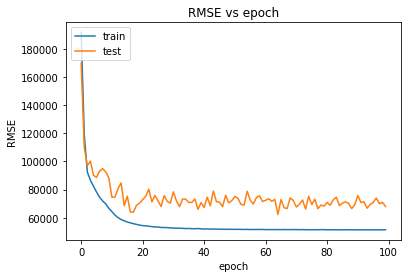

In [33]:
import math
import matplotlib.pyplot as plt

history1.history['root_mean_squared_error'] = []
history1.history['val_root_mean_squared_error'] = []

for i in range(len(history1.history['loss'])):
    history1.history['root_mean_squared_error'].append(math.sqrt(history1.history['loss'][i]))

for i in range(len(history1.history['val_loss'])):
    history1.history['val_root_mean_squared_error'].append(math.sqrt(history1.history['val_loss'][i]))

plt.plot(history1.history['root_mean_squared_error'])
plt.plot(history1.history['val_root_mean_squared_error'])
plt.title('RMSE vs epoch')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [34]:
test_loss = history1.history['val_root_mean_squared_error']

min_epoch_loss = 0
min_loss = float("inf")
for i,loss in enumerate(test_loss):
    if loss<min_loss:
        min_loss = loss
        min_epoch_loss = i+1

print(min_epoch_loss)
print(min_loss)



65
62334.73099324325


In [57]:
from keras import backend as K

# feedforward network with one hidden layer
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)

model2 = keras.Model(all_inputs, output)

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model2.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=[R2])

In [58]:
history2 = model2.fit(train_ds, epochs=5, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 6s 7ms/step - loss: 21969743872.0000 - R2: 0.0721 - val_loss: 13154531328.0000 - val_R2: 0.4927
Epoch 2/5
683/683 [==============================] - 5s 6ms/step - loss: 9137059840.0000 - R2: 0.6109 - val_loss: 10905063424.0000 - val_R2: 0.5768
Epoch 3/5
683/683 [==============================] - 5s 6ms/step - loss: 8437843456.0000 - R2: 0.6390 - val_loss: 10190435328.0000 - val_R2: 0.6049
Epoch 4/5
683/683 [==============================] - 5s 7ms/step - loss: 8081644544.0000 - R2: 0.6541 - val_loss: 11265838080.0000 - val_R2: 0.5616
Epoch 5/5
683/683 [==============================] - 5s 6ms/step - loss: 7736546304.0000 - R2: 0.6691 - val_loss: 9130422272.0000 - val_R2: 0.6456


In [59]:
def build_and_train_model_question3(embeddings_list, epochs):
    all_features = layers.concatenate(embeddings_list)
    x = layers.Dense(10, activation="relu")(all_features)
    output = layers.Dense(1, activation="linear")(x)
    model = keras.Model(all_inputs, output)
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=[R2])
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])
    return history


In [61]:
scores = {}

features_to_embeddings = {
    'month': month_embedder_flattened,
    'flat_model_type': flat_model_type_embedder_flattened,
    'storey_range': storey_range_embedder_flattened,
    'floor_area_sqm': floor_area_sqm_encoded,
    'remaining_lease_years': remaining_lease_years_encoded,
    'degree_centrality': degree_centrality_encoded,
    'eigenvector_centrality': eigenvector_centrality_encoded,
    'dist_to_nearest_stn': dist_to_nearest_stn_encoded,
    'dist_to_dhoby': dist_to_dhoby_encoded
}

initial_features = [
    'month',
    'flat_model_type',
    'storey_range',
    'floor_area_sqm',
    'remaining_lease_years',
    'degree_centrality',
    'eigenvector_centrality',
    'dist_to_nearest_stn',
    'dist_to_dhoby'           
]

def convert_features_list_to_embeddings(features_list):
    embeddings_list = []
    for feature in features_list:
        embeddings_list.append(features_to_embeddings[feature])
    return embeddings_list





def calculate_best_epoch_R2(history):
    r2_scores = history.history['val_R2']
    best_epoch = 1
    for i in range(len(r2_scores)):
        if r2_scores[i]>r2_scores[best_epoch-1]:
            best_epoch = i+1
    return r2_scores[best_epoch-1]





def RFE(best_r2_score, features_list, scores):
    if not features_list or len(features_list)==1:
        return
    print(scores)
    for i,feature in enumerate(features_list):
        new_features_list = features_list[:i]+features_list[i+1:]
        new_embeddings_list = convert_features_list_to_embeddings(new_features_list)
        tf.keras.backend.clear_session()
        history = build_and_train_model_question3(new_embeddings_list, 5)
        r2 = calculate_best_epoch_R2(history)
        if r2>=best_r2_score:
            scores[tuple(new_features_list)] = r2
            RFE(r2, new_features_list, scores)

best_r2_score_all_features = calculate_best_epoch_R2(history2)
scores[tuple(initial_features)] = best_r2_score_all_features
RFE(best_r2_score_all_features ,initial_features, scores)
print(scores)
    



{('month', 'flat_model_type', 'storey_range', 'floor_area_sqm', 'remaining_lease_years', 'degree_centrality', 'eigenvector_centrality', 'dist_to_nearest_stn', 'dist_to_dhoby'): 0.6456136703491211}
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 5s 6ms/step - loss: 18720913408.0000 - R2: 0.1827 - val_loss: 11725713408.0000 - val_R2: 0.5470
Epoch 2/5
683/683 [==============================] - 4s 6ms/step - loss: 8775025664.0000 - R2: 0.6246 - val_loss: 9894539264.0000 - val_R2: 0.6164
Epoch 3/5
683/683 [==============================] - 5s 6ms/step - loss: 8318563328.0000 - R2: 0.6441 - val_loss: 10567047168.0000 - val_R2: 0.5907
Epoch 4/5
683/683 [==============================] - 5s 6ms/step - loss: 8001455616.0000 - R2: 0.6574 - val_loss: 10215740416.0000 - val_R2: 0.6025
Epoch 5/5
683/683 [==============================] - 5s 6ms/step - loss: 7594650112.0000 - R2: 0.6746 - val_loss: 9260623872.0000 - val_R2: 0.6406
Epoch 1/5
683/683 [==============================] - 5s 5ms/step - loss: 35409944576.0000 - R2: -0.5197 - val_loss: 26198237184.0000 - val_R2: -0.0118
Epoch 2/5
683/683 [==============================] - 4s 5ms/step - loss: 19896309760.0000 - R2: 0.1525 - val_loss: 24530

In [56]:
tf.keras.backend.clear_session()

In [62]:
scores



{('month',
  'flat_model_type',
  'storey_range',
  'floor_area_sqm',
  'remaining_lease_years',
  'degree_centrality',
  'eigenvector_centrality',
  'dist_to_nearest_stn',
  'dist_to_dhoby'): 0.6456136703491211,
 ('month',
  'flat_model_type',
  'storey_range',
  'floor_area_sqm',
  'remaining_lease_years',
  'eigenvector_centrality',
  'dist_to_nearest_stn',
  'dist_to_dhoby'): 0.6586373448371887}